In [38]:
from neo import Block
from neo.io import Spike2IO, NeoMatlabIO
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from kaveh.behavioral.oculomotor.trial import trial
from kaveh.sorting import spikesorter
from kaveh.toolbox import find_file
from kaveh.plots import axvlines
import numpy as np
from matplotlib import pyplot as plt
from smr import File
import csv
import os
import gc

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [21]:
# These are Buckley files with the following event structure:
# Event 0
# Event 1
# Event 2
# Event 3 : Trial onset
# Event 4 : Primary target presentation in adaptation trials
# Event 5 : Corrective target presentation in adaptation trials
# Event 6 : Divide each trial into its target jumps
# Event 7 : 
buckley_files_correct_events = ['B082107_1340_List.smr',
'B090407_1526_List.smr',
'B091208_1545_List.smr',
'B091608_1208_List.smr',
'B091707_1414_List.smr', 
'B091908_1_1500_List.smr', 
'B091908_2_1550_List.smr',
'B093008_1149_List.smr',
'B100308_2_1403_List.smr',
'B101707_1333_List.smr',
'B121407_1_1124_List.smr',
'W091008_1241_List.smr',
'W091208_1337_List.smr',
'W120108_1622_List.smr',
'W120208_1_1418_List.smr',
'W120308_2_1714_List.smr',
'W120508_1_1420_List.smr',
'W120508_2_1628_List.smr']


f_name = find_file(buckley_files_correct_events[2], '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
f_name_csv = find_file(buckley_files_correct_events[2]+'.pkl.csv', '../data/david_neurons')
print(f_name)
print(f_name_csv)
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B110807/B110807_1632_List.smr'

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091208/B091208_1545_List.smr
../data/david_neurons/B091208/B091208_1545_List.smr.pkl.csv


In [22]:
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]
events = seg.events

In [23]:
# Load events
labels = np.unique(events[-1].labels)

event_times = [0]*labels.size

for i, label in enumerate(labels):
    event_times[i] = events[-1].times[events[-1].labels == label]
    
# Event 0
# Event 1
# Event 2
# Event 3 : Trial onset
# Event 4 : Primary target presentation in adaptation trials
# Event 5 : Corrective target presentation in adaptation trials
# Event 6 : Divide each trial into its target jumps
# Event 7 : 

In [6]:
for et in event_times:
    print(et.shape)

(699,)
(560,)
(1,)
(18,)
(280,)
(279,)
(141,)
(59,)
(1,)


In [24]:
# Load eye data
HE = seg.analogsignals[0].as_array()
t_HE = seg.analogsignals[0].times;

VE = seg.analogsignals[1].as_array()
t_VE = seg.analogsignals[1].times

HT = seg.analogsignals[2].as_array()
t_HT = seg.analogsignals[2].times

VT = seg.analogsignals[3].as_array()
t_VT = seg.analogsignals[3].times

eye_fs = seg.analogsignals[0].sampling_rate



In [30]:
# Load cs times from smr files

cs_times = seg.spiketrains[0].times
cs_times.shape

(14549,)

In [32]:
# Load cs times from csGUI csv files

with open(f_name_csv, 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader), dtype=np.int64)

cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
cs_times = t_signal[cs_indices]
cs_times.shape

(566,)

(566,)

In [33]:
# Load voltage
signal = seg.analogsignals[-1].as_array()
t_signal = seg.analogsignals[-1].times
signal_fs = seg.analogsignals[-1].sampling_rate

In [39]:
# create a list of trials based on wether events indicating primary target presentations 
# in adaptation trials exist or not (this is the way most of 2010_Adapt files are structured)
trial_num = 0
start_time = event_times[3][trial_num]
end_time = event_times[3][trial_num + 1]
trials = []

while np.any(np.where((event_times[4] < end_time) & (event_times[4] > start_time))):
    print(trial_num)
    primary_target_times = event_times[4][np.where((event_times[4] < end_time) & (event_times[4] > start_time))]
    corrective_target_times = event_times[5][np.where((event_times[5] < end_time) & (event_times[5] > start_time))]
    trial_signal = signal[(t_signal > start_time) & (t_signal <= end_time)]
    trial_t_signal = t_signal[(t_signal > start_time) & (t_signal <= end_time)]
    trial_cs_times = cs_times[(cs_times > start_time) & (cs_times <= end_time)]
    
    trial_HT = HT[(t_HT > start_time) & (t_HT <= end_time)]
    trial_t_HT = t_HT[(t_HT > start_time) & (t_HT <= end_time)]
    
    trial_VT = VT[(t_VT > start_time) & (t_VT <= end_time)]
    trial_t_VT = t_VT[(t_VT > start_time) & (t_VT <= end_time)]
    
    trials = trials + [trial(trial_num, start_time, end_time, primary_target_times,
                             corrective_target_times, cs_times=trial_cs_times,
                             HT=trial_HT, t_HT= trial_t_HT, VT=trial_VT, t_VT=trial_t_VT,
                             signal=trial_signal, t_signal=trial_t_signal)]
    trial_num = trial_num + 1
    if trial_num < len(event_times[3]) - 1:
        start_time = event_times[3][trial_num]
        end_time = event_times[3][trial_num + 1]
    else:
        break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [40]:
print(trials[0].trial_number)
print(trials[0].start_time)
print(trials[0].end_time)
print(trials[0].primary_target_times)
print(trials[0].corrective_target_times)
print(trials[0].t_signal[0], trials[0].t_signal[-1])
print(trials[0].signal.shape)
print(trials[0].cs_times)

0
0.021629999999999996 s
25.97394 s
[ 0.9248   1.99687  4.09924  5.18738  7.28976  8.36988 10.47224 11.5343
 13.63669 14.66582 16.76817 17.89723 20.52661 21.6007  23.70308 24.77418] s
[ 1.09389  2.158    4.28438  5.32848  7.4669   8.52898 10.63133 11.89744
 13.76282 14.80691 16.99426 17.89732 20.69771 21.78884 23.87118 24.93332] s
(array(0.02164) * s, array(25.97394) * s)
(1297616, 1)
[ 0.73432  2.33404  2.47632  2.71256  2.75736  3.62806  3.96416  4.30444
  4.89188  5.2629   6.49672  7.33776  8.26072  8.52378  8.75756  8.98578
  9.78688 10.8757  12.07482 12.6402  13.45122 13.56692 14.61078 16.24842
 16.60598 16.83182 17.32686 18.97768 19.3377  19.3854  19.78894 20.30158
 20.40852 22.10926 22.82086 23.34474 23.3908  23.59036] s


In [13]:
# import quantities as pq
# t_range = pq.quantity.Quantity(0.01, 's')
# curr_trial = trials[0]
# for i, ptt in enumerate(curr_trial.primary_target_times):
# # ptt = curr_trial.primary_target_times[5]
#     ht_vector = curr_trial.HT[np.where(np.logical_and(curr_trial.t_HT < (ptt + t_range), curr_trial.t_HT > (ptt - t_range)))]
#     ht_vector = ht_vector[-1] - ht_vector[0]
#     if (np.abs(ht_vector) < 0.2): ht_vector = 0
#     vt_vector = curr_trial.VT[np.where(np.logical_and(curr_trial.t_VT < (ptt + t_range), curr_trial.t_VT > (ptt - t_range)))]
#     vt_vector = vt_vector[-1] - vt_vector[0]
#     if (np.abs(vt_vector) < 0.2): vt_vector = 0;

#     print(i+1, get_direction_angle(ht_vector, vt_vector))
    


In [14]:
# import quantities as pq
# t_range = pq.quantity.Quantity(0.01, 's')
# curr_trial = trials[0]
# for i, ptt in enumerate(curr_trial.corrective_target_times):
# # ptt = curr_trial.primary_target_times[5]
#     ht_vector = curr_trial.HT[np.where(np.logical_and(curr_trial.t_HT < (ptt + t_range), curr_trial.t_HT > (ptt - t_range)))]
#     ht_vector = ht_vector[-1] - ht_vector[0]
#     if (np.abs(ht_vector) < 0.2): ht_vector = 0
#     vt_vector = curr_trial.VT[np.where(np.logical_and(curr_trial.t_VT < (ptt + t_range), curr_trial.t_VT > (ptt - t_range)))]
#     vt_vector = vt_vector[-1] - vt_vector[0]
#     if (np.abs(vt_vector) < 0.2): vt_vector = 0;

#     print(i+1, get_direction_angle(ht_vector, vt_vector))

In [41]:
import quantities as pq
cs_range = pq.quantity.Quantity(0.250, 's')

fired_complex_spikes_corrective = np.zeros((len(trials[0:26]), 16))
fired_complex_spikes_primary = np.zeros((len(trials[0:26]), 16))


trial_num = 0
for i, trial in enumerate(trials[0:-2]):
# trial = trials[trial_num]
#     print(trial.primary_target_dir)
#     print(trial.corrective_target_dir)
    for j, ptt in enumerate(trial.corrective_target_times):
        fired_complex_spikes_corrective[i][j] = np.count_nonzero(np.where(np.logical_and(trial.cs_times < ptt+cs_range, trial.cs_times > ptt )))
    for j, ptt in enumerate(trial.primary_target_times):
        fired_complex_spikes_primary[i][j] = np.count_nonzero(np.where(np.logical_and(trial.cs_times < ptt+cs_range, trial.cs_times > ptt )))
    

directions = np.unique(trials[0].corrective_target_dir)
dir_idx = {}
for d in directions:
    dir_idx[d] = np.where(trials[0].corrective_target_dir == d)[0]

<IPython.core.display.Javascript object>


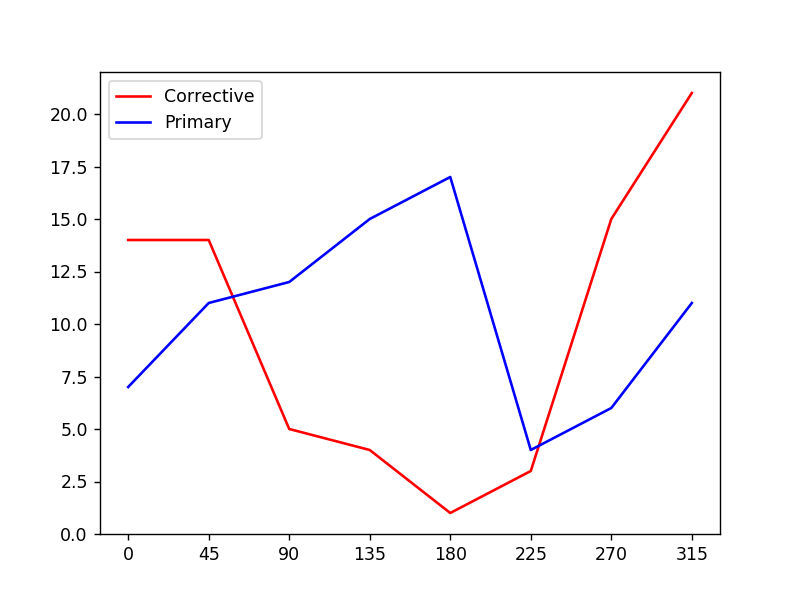

In [42]:
cs_rate_primary = {}
cs_rate_corrective = {}
for d in dir_idx:
    cs_rate_primary[d] = np.sum(fired_complex_spikes_primary[:, dir_idx[d]])
    cs_rate_corrective[d] = np.sum(fired_complex_spikes_corrective[:, dir_idx[d]])
    

[x,y] = zip(*sorted(cs_rate_corrective.items()))
plt.figure()
plt.plot(x,y, 'r')
[x,y] = zip(*sorted(cs_rate_primary.items()))
plt.plot(x,y, 'b')
plt.xticks(x)

plt.legend(['Corrective', 'Primary'])

In [343]:
cs_rate

{0.0: 6.0,
 45.0: 7.0,
 90.0: 4.0,
 135.0: 7.0,
 180.0: 5.0,
 225.0: 3.0,
 270.0: 14.0,
 315.0: 5.0}

In [342]:
cs_rate.values()

[6.0, 3.0, 7.0, 7.0, 14.0, 5.0, 4.0, 5.0]

<IPython.core.display.Javascript object>


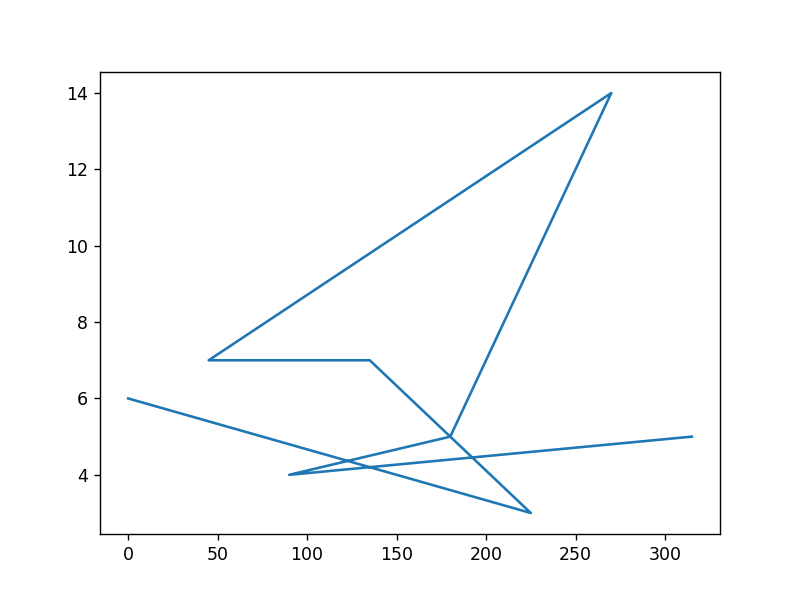

In [339]:
plt.figure()
plt.plot(cs_rate.keys(), cs_rate.values())

<IPython.core.display.Javascript object>


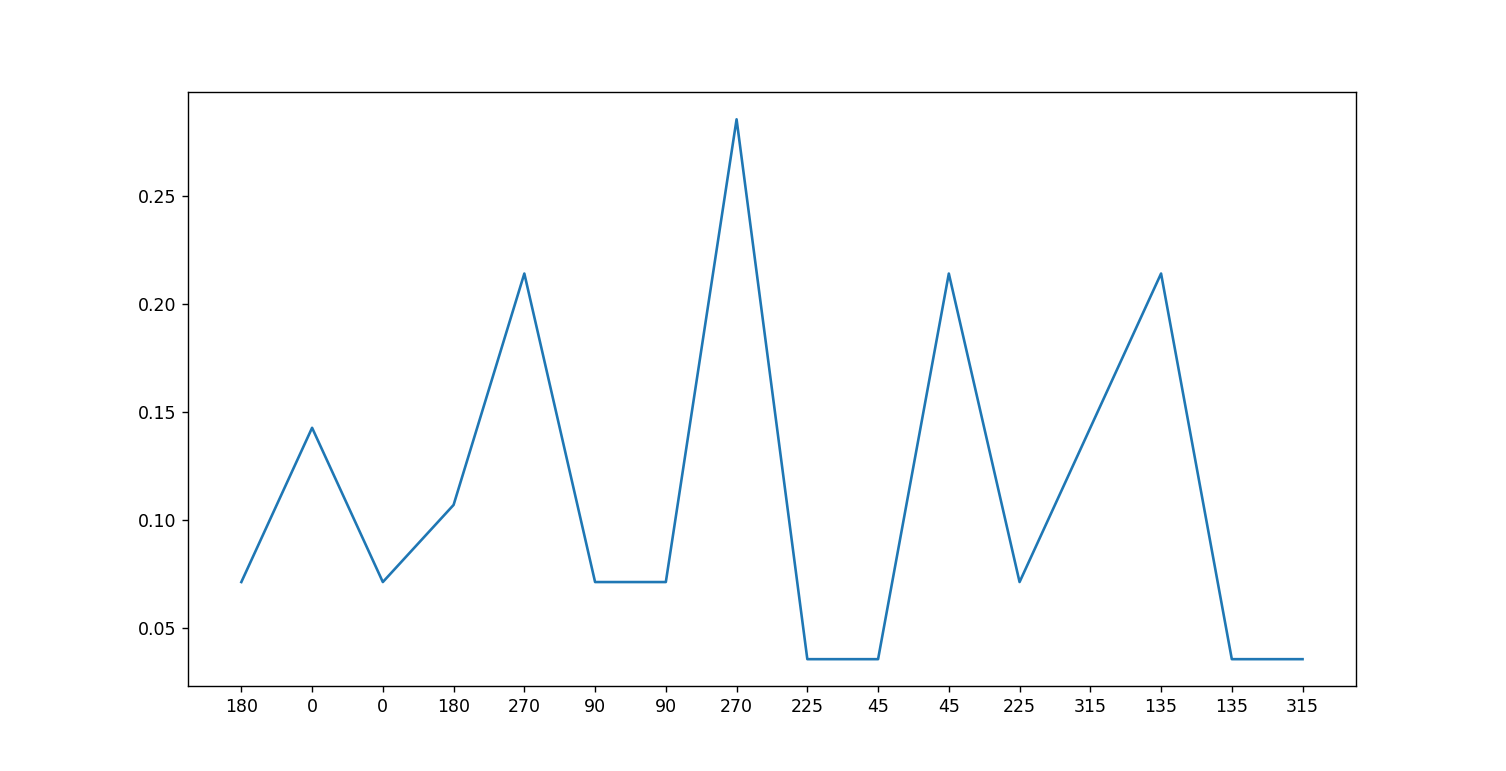

([<matplotlib.axis.XTick at 0x7fe14942e690>,
 <a list of 16 Text xticklabel objects>)

In [313]:
plt.figure()
dirs = [str(int(direction)) for direction in trials[0].corrective_target_dir]
plt.plot(np.arange(0,16), np.sum(fired_complex_spikes, axis = 0)/len(trials))
plt.xticks(np.arange(0,16), dirs)

In [292]:
np.shape(np.sum(fired_complex_spikes, axis = 0)/len(trials))
dirs.shape

(16,)

In [519]:
trial_num = 28
start_time = event_times[3][trial_num]
end_time = event_times[3][trial_num + 1]
any((event_times[4] < end_time) & (event_times[4] > start_time))

False

<IPython.core.display.Javascript object>


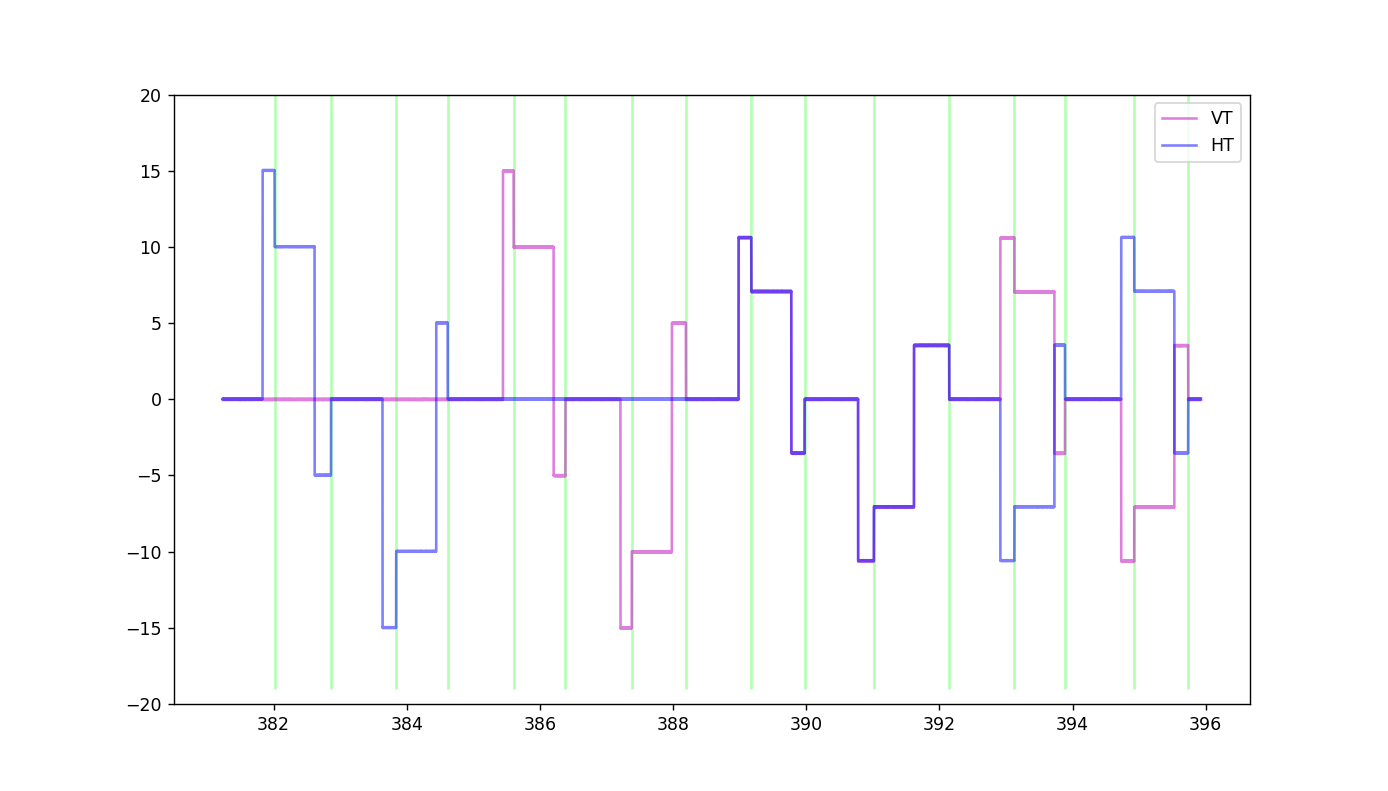

In [161]:
# divide trials
trial_num = 26

start_time = event_times[3][trial_num]
end_time = event_times[3][trial_num + 1]

gc.collect()
plt.figure()
plt.plot(t_VT[(t_VT > start_time) & (t_VT <= end_time)], VT[(t_VT > start_time) & (t_VT <= end_time)], alpha = 0.5, color = 'm')
plt.plot(t_HT[(t_HT > start_time) & (t_HT <= end_time)], HT[(t_HT > start_time) & (t_HT <= end_time)], alpha = 0.5, color = 'b')
# plt.plot(t_VE[(t_VE > start_time) & (t_VE <= end_time)], VE[(t_VE > start_time) & (t_VE <= end_time)], alpha = 0.5, color = 'g')
# plt.plot(t_HE[(t_HE > start_time) & (t_HE <= end_time)], HE[(t_HE > start_time) & (t_HE <= end_time)], alpha = 0.5, color = 'y')
plt.legend(['VT', 'HT', 'VE', 'HE'])
plt.ylim((-20, 20))
# plt.eventplot(prim_sac_times_adpt[(prim_sac_times_adpt > start_time) & (prim_sac_times_adpt <= end_time)], linelengths=40, colors='r', alpha = 0.3)
plt.eventplot(corr_sac_times_adpt[(corr_sac_times_adpt > start_time) & (corr_sac_times_adpt <= end_time)], linelengths=40, colors='lime', alpha = 0.3)
plt.show()

<IPython.core.display.Javascript object>


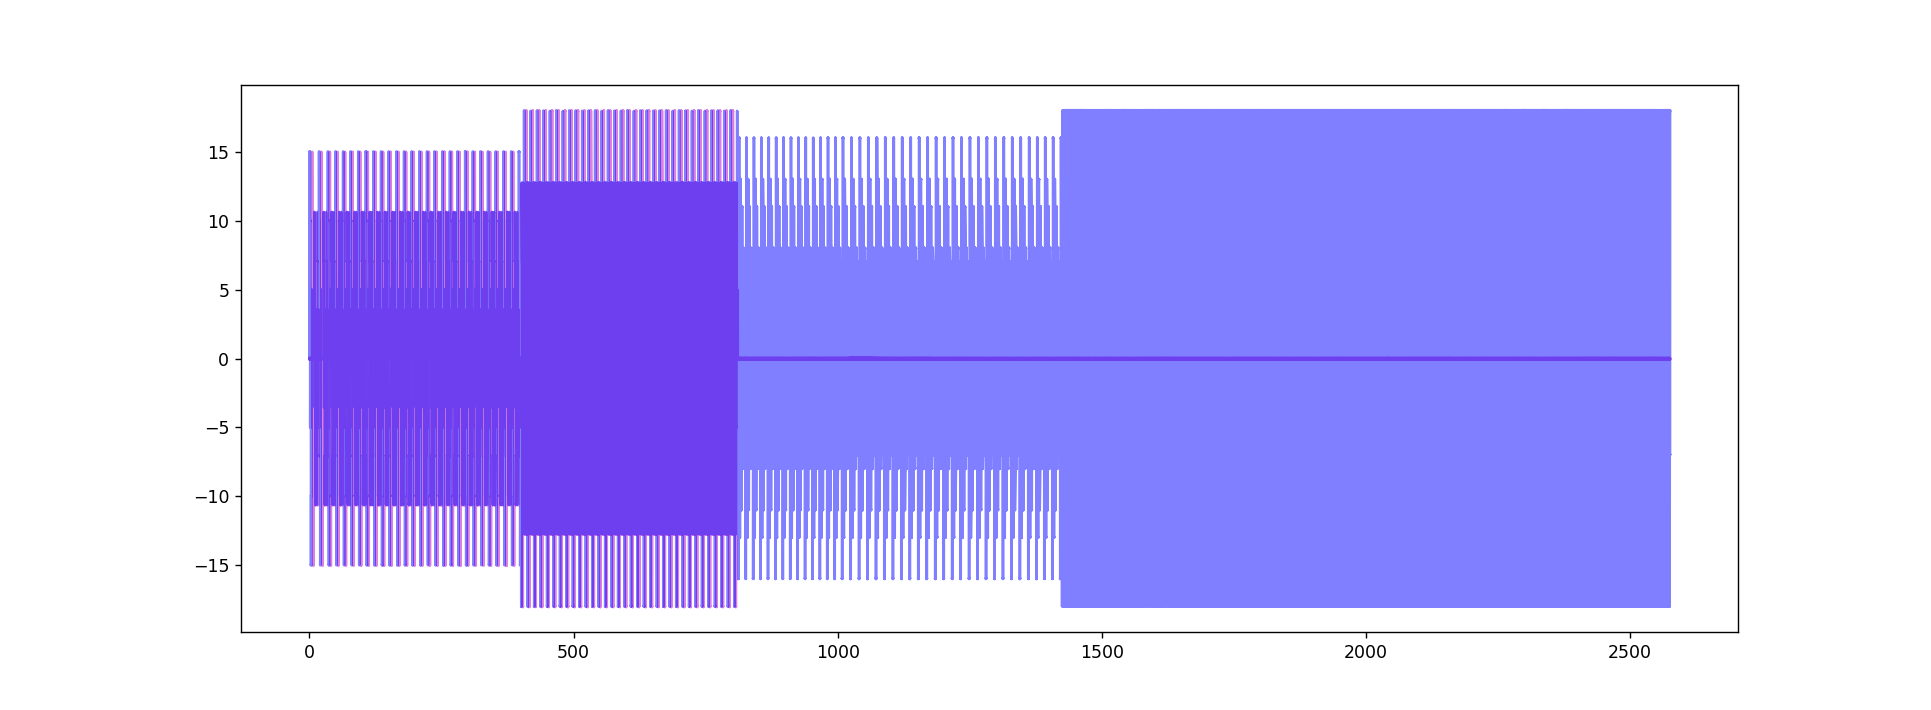

In [160]:
plt.figure()
plt.plot(t_VT, VT, alpha = 0.5, color = 'm')
plt.plot(t_HT, HT, alpha = 0.5, color = 'b')